In [1]:
import pandas as pd
from datetime import datetime
import numpy as np

import matplotlib.pyplot as plt

In [2]:
fraud_cases = pd.read_csv("data/fraud_cases.csv")
CH_train = pd.read_csv("data/FRISS_ClaimHistory_training.csv")
CH_test = pd.read_csv("data/FRISS_ClaimHistory_test.csv")

### Initial data cleaning
Drop columns with only one value

In [3]:
drop_cols = []
for column in CH_train.columns:
  if len(CH_train[column].value_counts()) == len(CH_test[column].value_counts()) == 1:
    drop_cols.append(column)
    
CH_train = CH_train.drop(columns=drop_cols)
CH_test = CH_test.drop(columns=drop_cols)
print(f"dropped useless columns: {drop_cols}")

dropped useless columns: ['sys_sector', 'sys_label', 'sys_process', 'sys_product', 'sys_dataspecification_version', 'sys_currency_code']


Convert claim ID format in ClaimHistory files to format found in fraud cases file

In [4]:
CH_train["sys_claimid"] = CH_train["sys_claimid"].map(lambda x: x[4:-3])
CH_test["sys_claimid"] = CH_test["sys_claimid"].map(lambda x: x[4:-3])

Three fraud cases contain 2 slash-separated claim IDs, however only the first ones map to the ClaimHistory files, so only the first ones are kept.

In [5]:
fraud_cases["ClaimID"] = fraud_cases["ClaimID"].map(lambda x: x[:9])

Merge the trainset with fraud cases using outer join, then using the "Date_Occurred" column in the merged df, create fraud feature using the same format found in the testset, then drop useless columns

In [6]:
CH_train = pd.merge(CH_train, fraud_cases,
               left_on=["sys_claimid", "claim_date_occurred"],
               right_on=["ClaimID", "Date_Occurred"],
               how="outer")

def date_claimed_to_fraud(date):
  return 0.0 if pd.isna(date) else 1.0

CH_train["sys_fraud"] = CH_train["Date_Occurred"].map(date_claimed_to_fraud)
CH_train = CH_train.drop(columns=["ClaimID", "Date_Occurred"])

In [7]:
train_fraud_rate = CH_train["sys_fraud"].value_counts()[1]/len(CH_train)
test_fraud_rate = CH_test["sys_fraud"].value_counts()[1]/len(CH_test)

print("Train set fraud rate:\t {0:.2}%".format(train_fraud_rate*100))
print("Test set fraud rate:\t {0:.2}%".format(test_fraud_rate*100))

Train set fraud rate:	 0.77%
Test set fraud rate:	 0.68%


Convert claim data columns to datetime and create time_interval column.

In [8]:
CH_train["claim_date_reported"] = pd.to_datetime(CH_train["claim_date_reported"].astype(str))
CH_train["claim_date_occurred"] = pd.to_datetime(CH_train["claim_date_occurred"].astype(str))

CH_test["claim_date_reported"] = pd.to_datetime(CH_test["claim_date_reported"].astype(str))
CH_test["claim_date_occurred"] = pd.to_datetime(CH_test["claim_date_occurred"].astype(str))

CH_train["claim_time_interval"] = CH_train["claim_date_reported"] - CH_train["claim_date_occurred"] 
CH_train["claim_time_interval"] = CH_train["claim_time_interval"].map(lambda x: x.days)

CH_test["claim_time_interval"] = CH_test["claim_date_reported"] - CH_train["claim_date_occurred"] 
CH_test["claim_time_interval"] = CH_test["claim_time_interval"].map(lambda x: x.days)

In both sets' "claim_date_reported" column some future values are present (compared to time of writing) Both sets show a sharp decline of entries after the first months of 2018.

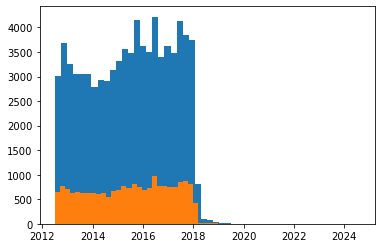

In [9]:
_ = plt.hist(CH_train["claim_date_reported"], bins=50)
_ = plt.hist(CH_test["claim_date_reported"], bins=50)

Entries containing a reported date after the first half of 2018 are dropped as they could be errors. 

In [10]:
CH_test = CH_test[CH_test["claim_date_reported"]<pd.to_datetime("2018-07-01")]
CH_train = CH_train[CH_train["claim_date_reported"]<pd.to_datetime("2018-07-01")]

The same behaviour can not be observed in the "claim_date_occurred" column

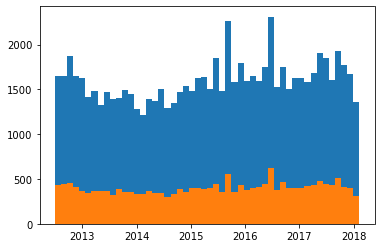

In [11]:
_ = plt.hist(CH_train["claim_date_occurred"], bins=50)
_ = plt.hist(CH_test["claim_date_occurred"], bins=50)

### High intervals
To find high values of time_interval, first I check some normality tests to determine whether outlier detection can be used

Shapiro test:	stat: 2.986e-01	 p: 0.0000e+00
K-squared test:	stat: 1.271e+05	 p: 0.0000e+00
X-squared test:	stat: 1.326e+07	 p: 0.0000e+00


/home/orlando/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


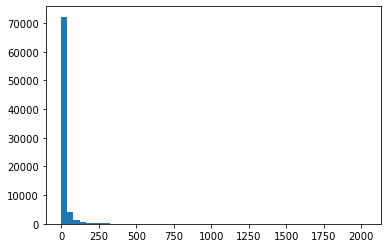

In [12]:
from scipy.stats import shapiro, normaltest, chisquare

data = CH_train["claim_time_interval"]

_ = plt.hist(data, bins=50)

stat, p = shapiro(data)
print("Shapiro test:\tstat: {0:.3e}\t p: {1:.4e}".format(stat, p))

stat, p = normaltest(data)
print("K-squared test:\tstat: {0:.3e}\t p: {1:.4e}".format(stat, p))

stat, p = chisquare(data)
print("X-squared test:\tstat: {0:.3e}\t p: {1:.4e}".format(stat, p))

Data is non-normal, considering the sharp decline in time_intervals in the above graph, excluding the top x% values could be one solution for identifying high time_intervals.First I check whether there is a relationship between higher time intervals and fraud rate


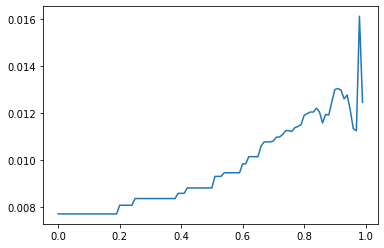

In [13]:
l = list(CH_train["claim_time_interval"].sort_values())

percentage_range = np.arange(0, 1, 0.01)
fraud_rates = []


for i in percentage_range:
  ti = l[int(len(l)*i)] # Interval at the i-th percentile
  pi = np.mean(CH_train[CH_train["claim_time_interval"]>=ti]["sys_fraud"]) # Fraud rate for values above ti
  fraud_rates.append(pi)
  
_ = plt.plot(percentage_range, fraud_rates)

While higher time-intervals seem to correlate with higher fraud rates, there does not seem to be a pivot point at which the rate starts increasing quickly. Based on this, a value between 85% and 90% could be a good spot to start calling intervals "high" without overusing the indicator. For the sake of explainability, I would propose a value of 30 or 31 days, as that falls between the two above mentioned percentages.

In [14]:
i85 = l[int(len(l)*0.85)]
i90 = l[int(len(l)*0.90)]

p85 = np.mean(CH_train[CH_train["claim_time_interval"]>=i85]["sys_fraud"])
p90 = np.mean(CH_train[CH_train["claim_time_interval"]>=i90]["sys_fraud"])

print("15% of claims have an interval higher of {0}, with a fraud rate of {1:.4f}".format(i85, p85))
print("10% of claims have an interval higher of {0}, with a fraud rate of {1:.4f}".format(i90, p90))

15% of claims have an interval higher of 26, with a fraud rate of 0.0121
10% of claims have an interval higher of 40, with a fraud rate of 0.0130


### Further data cleaning
Having initially removed trivially useless features, additional columns need to be removed.
To avoid biasing the model, the policy holder's gender is removed from the data.
The policy holder's first and last name are likewise removed, both to avoid biasing the model against certain ethnicities, and because the granularity of the data renders the information very hard to use. 

In [15]:
# TODO: check feasibility and usefulness of counting policy holder's claim amount

In [16]:
drop_cols = ["ph_gender", "ph_name", "ph_firstname"]
CH_train = CH_train.drop(columns = drop_cols)
CH_test = CH_test.drop(columns = drop_cols)

2 columns contain NaN values: 'claim_causetype' and 'policy_insured_amount', the first has a low number of missing values, so I drop the entries missing a causetype value.

In [17]:
CH_train = CH_train.dropna(subset=['claim_causetype'])
CH_test = CH_test.dropna(subset=['claim_causetype'])

However, doing the same for 'policy_insured_amount' would significantly reduce the number of entries as there are many missing values. For now I substitute the NaNs the mean of the column, and I will later evaluate whether removing the column altogether is advisable.

In [18]:
CH_train['policy_insured_amount'] = CH_train['policy_insured_amount'].fillna(
                                                  CH_train['policy_insured_amount'].mean())

CH_test['policy_insured_amount'] = CH_test['policy_insured_amount'].fillna(
                                                  CH_test['policy_insured_amount'].mean())

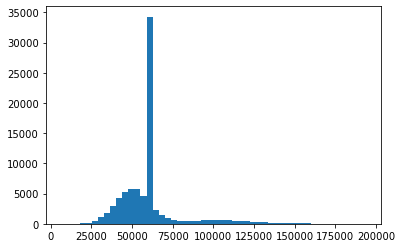

In [19]:
_ = plt.hist(CH_train['policy_insured_amount'], bins = 50)

In [20]:
CH_train.columns

Index(['sys_claimid', 'claim_amount_claimed_total', 'claim_causetype',
       'claim_date_occurred', 'claim_date_reported',
       'claim_location_urban_area', 'object_make', 'object_year_construction',
       'policy_fleet_flag', 'policy_insured_amount', 'policy_profitability',
       'sys_fraud', 'claim_time_interval'],
      dtype='object')

In [21]:
CH_train.head()

,sys_claimid,claim_amount_claimed_total,claim_causetype,claim_date_occurred,claim_date_reported,claim_location_urban_area,object_make,object_year_construction,policy_fleet_flag,policy_insured_amount,policy_profitability,sys_fraud,claim_time_interval
0,338957796,2433.0,Collision,2012-10-22,2012-11-27,1,VOLKSWAGEN,2008.0,0,74949.000000,Low,0.0,36
1,434911509,3791.0,Collision,2014-06-12,2014-06-18,1,CITROEN,2003.0,0,100648.000000,Very low,0.0,6
2,615568027,452.0,Collision,2013-05-06,2013-09-23,1,RENAULT,2001.0,0,59950.850994,Low,0.0,140
3,917387010,555.0,Collision,2017-11-12,2017-12-06,1,RENAULT,2017.0,0,121081.000000,High,0.0,24
4,281513737,382.0,Collision,2015-10-21,2015-12-02,1,BMW,2011.0,0,94538.000000,Very high,0.0,42


I substitute categorical values with dummy columns

In [22]:
CH_train = pd.concat([CH_train.drop('claim_causetype', axis=1),
                pd.get_dummies(CH_train['claim_causetype'], prefix='cause')], axis=1)
CH_train = pd.concat([CH_train.drop('object_make', axis=1),
                pd.get_dummies(CH_train['object_make'], prefix='make')], axis=1)

CH_test = pd.concat([CH_test.drop('claim_causetype', axis=1),
                pd.get_dummies(CH_test['claim_causetype'], prefix='cause')], axis=1)
CH_test = pd.concat([CH_test.drop('object_make', axis=1),
                pd.get_dummies(CH_test['object_make'], prefix='make')], axis=1)

In [26]:
CH_train['policy_profitability'].value_counts()

Very low     17478
Low          16768
Neutral      15836
High         15260
Very high    14476
Name: policy_profitability, dtype: int64

For profitability, instead of dummy variables I change each value with a number from 0 to 4

In [31]:
profitability_map = {'Very low': 0,
                     'Low': 1,
                     'Neutral': 2,
                     'High': 3,
                     'Very high': 4}
CH_train['policy_profitability'] = CH_train['policy_profitability'].map(profitability_map)
CH_test['policy_profitability'] = CH_test['policy_profitability'].map(profitability_map)

I decompose date features into year-month-day

In [46]:
CH_train['occurred_year'] = CH_train["claim_date_occurred"].dt.year
CH_train['occurred_month'] = CH_train["claim_date_occurred"].dt.month
CH_train['occurred_day'] = CH_train["claim_date_occurred"].dt.day

CH_train['reported_year'] = CH_train["claim_date_reported"].dt.year
CH_train['reported_month'] = CH_train["claim_date_reported"].dt.month
CH_train['reported_day'] = CH_train["claim_date_reported"].dt.day

CH_test['occurred_year'] = CH_test["claim_date_occurred"].dt.year
CH_test['occurred_month'] = CH_test["claim_date_occurred"].dt.month
CH_test['occurred_day'] = CH_test["claim_date_occurred"].dt.day

CH_test['reported_year'] = CH_test["claim_date_reported"].dt.year
CH_test['reported_month'] = CH_test["claim_date_reported"].dt.month
CH_test['reported_day'] = CH_test["claim_date_reported"].dt.day

In [48]:
CH_train = CH_train.drop(columns=["claim_date_occurred", "claim_date_reported"])
CH_test = CH_test.drop(columns=["claim_date_occurred", "claim_date_reported"])

In [57]:
import preprocessing

In [58]:
preprocessing.preprocess()

TypeError: preprocess() missing 3 required positional arguments: 'train_file', 'test_file', and 'fraud_file'